In [11]:
import tensorflow as tf
from sklearn.svm import LinearSVC, SVC
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split
import time
import sys
import getopt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

import csv
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support



%matplotlib inline

In [12]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content/drive/My Drive/INSAID/cmdinjection.csv
(2880, 36)
/content/drive/My Drive/INSAID/DVWA_Normal.csv
(2279, 36)
/content/drive/My Drive/INSAID/DVWA_SQLInjection1.csv
(2520, 36)
train_X vlues
(7679, 36)
train_Y vlues
(7679,)
Linear SVM Testing...
score testing 0.9954427083333334
FPR [0. 0. 1.]
TPR [0.         0.99340245 1.        ]
ACC 0.9967012252591895
prec 0.9954427083333334 recall 0.9954427083333334 Fscore 0.9954427083333334
K8s Anomaly test...
Epoch 1/30
48/48 [==============================] - 1s 7ms/step - loss: 0.6050 - accuracy: 0.6892 - val_loss: 0.4833 - val_accuracy: 0.7832
Epoch 2/30
48/48 [==============================] - 0s 4ms/step - loss: 0.4692 - accuracy: 0.8130 - val_loss: 0.4048 - val_accuracy: 0.7826
Epoch 3/30
48/48 [==============================] - 0s 4ms/step - loss: 0.3838 - accuracy: 0.8510 - val_loss: 0.3046 - val_accuracy: 0.9206
Epoch 4/30
48/48 [==============================] - 0s 4ms/step - loss: 0.2798 - accuracy: 0.9314 - val_loss: 0.2201 - val_

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


48/48 [==============================] - 1s 7ms/step - loss: 0.5623 - accuracy: 0.7268 - val_loss: 0.4176 - val_accuracy: 0.7819
Epoch 2/30
48/48 [==============================] - 0s 4ms/step - loss: 0.3944 - accuracy: 0.8565 - val_loss: 0.2902 - val_accuracy: 0.9212
Epoch 3/30
48/48 [==============================] - 0s 4ms/step - loss: 0.2589 - accuracy: 0.9432 - val_loss: 0.1859 - val_accuracy: 0.9531
Epoch 4/30
48/48 [==============================] - 0s 4ms/step - loss: 0.1856 - accuracy: 0.9627 - val_loss: 0.1180 - val_accuracy: 0.9740
Epoch 5/30
48/48 [==============================] - 0s 4ms/step - loss: 0.1490 - accuracy: 0.9631 - val_loss: 0.0821 - val_accuracy: 0.9811
Epoch 6/30
48/48 [==============================] - 0s 4ms/step - loss: 0.1164 - accuracy: 0.9709 - val_loss: 0.0814 - val_accuracy: 0.9759
Epoch 7/30
48/48 [==============================] - 0s 4ms/step - loss: 0.1212 - accuracy: 0.9688 - val_loss: 0.0613 - val_accuracy: 0.9824
Epoch 8/30
48/48 [=============

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


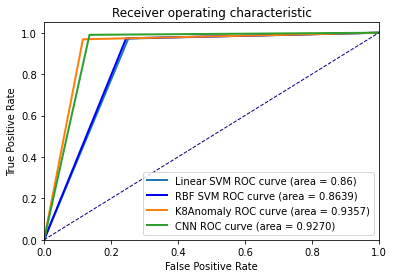

In [13]:
class Dataset():
    def __init__(self, path=None, Normalize=False, Normalize_method='std'):
        if path == None:
            print('Path cannot be None')
            exit()
        print(path)
        # Load data

        self.X = []
        self.Y = []

        with open(path, 'rt') as csvfile:
            csv_reader = csv.reader(csvfile)
            # csv_reader = csv.DictReader(csvfile)
            for idx, row in enumerate(csv_reader):
                if idx == 0:
                    continue
                self.X.append([float(v) for v in row[1:37]])
                # self.X.append([float(v) for v in [row[16],row[25], row[34], row[26], row[13], row[17], row[23], row[19], row[5], row[31], row[21], row[28], 0, row[2], row[33], row[36] ]])
                self.Y.append([int(v) for v in row[37:]].index(1))
        if Normalize:
            self.X = np.array(self.X)

            if Normalize_method == 'std':
                normalizer = StandardScaler()
            elif Normalize_method == 'l2':
                normalizer = Normalizer()

            self.X = normalizer.fit_transform(self.X)
            self.Y = np.array(self.Y)
        else:
            self.X = np.array(self.X)
            self.Y = np.array(self.Y)

class k8sAnomaly_Model():
    train_X = []
    train_Y = []
    cnn_flag = False
    #Complex data set
    data_path = ['/content/drive/My Drive/INSAID/cmdinjection.csv', '/content/drive/My Drive/INSAID/DVWA_Normal.csv', '/content/drive/My Drive/INSAID/DVWA_SQLInjection1.csv']

    for path in data_path:
        ds = Dataset(path, Normalize=True, Normalize_method='l2')
        train_X.append(ds.X)
        train_Y.append(ds.Y)
        print(ds.X.shape)
    # print(ds.Y.shape)
    train_X = np.concatenate(train_X)
    train_Y = np.concatenate(train_Y)
    print('train_X vlues')
    print(train_X.shape)
    print('train_Y vlues')
    print(train_Y.shape)

    X_train, X_test, Y_train, Y_test = train_test_split(train_X, train_Y, test_size=0.2, random_state=1)
    y_GT = Y_test
    model = tf.keras.models.Sequential()


    def generate_plot_figure(self):
        # this file is u        sed to generate plots for paper


        liSVM_fpr = [0.       ,  0.18626645 ,1.]
        liSVM_tpr = [0.       ,  0.95863115 ,1.        ]


        rbfSVM_fpr = [0.   ,  0.3125 ,1.    ]
        rbfSVM_tpr = [0.  ,      0.96902751, 1.        ]


        MLP_fpr = [0.        , 0.10567434 ,1.        ]
        MLP_tpr = [0.        , 0.99978341 ,1.        ]


        CNN_fpr = [0.      ,   0.12417763 ,1.        ]
        CNN_tpr = [0.       ,  0.99870045 ,1.        ]


        liSVM_fpr = [0.      ,   0.25164474 ,1.        ]
        liSVM_tpr = [0.       ,  0.97184319 ,1.        ]


        rbfSVM_fpr = [0.       ,  0.24506579 ,1.        ]
        rbfSVM_tpr = [0.       ,  0.97292614 ,1.        ]


        MLP_fpr = [0.      ,   0.12088816 ,1.        ]
        MLP_tpr = [0.      ,   0.99241932 ,1.        ]

        MLP_fpr = [0.      ,   0.11595395 ,1.        ]
        MLP_tpr = [0.      ,   0.96816114 ,1.        ]

        CNN_fpr = [0.      ,   0.13569079 ,1.       ]
        CNN_tpr = [0.     ,    0.98982023 ,1.        ]


        plt.figure()
        lw = 1
        plt.plot(liSVM_fpr, liSVM_tpr,lw=2, label='Linear SVM ROC curve (area = 0.86)')
        plt.plot(rbfSVM_fpr, rbfSVM_tpr,lw=2, label='RBF SVM ROC curve (area = 0.8639)',color='b')
        plt.plot(MLP_fpr, MLP_tpr,lw=2, label='K8Anomaly ROC curve (area = 0.9357)')
        plt.plot(CNN_fpr, CNN_tpr,lw=2, label='CNN ROC curve (area = 0.9270)')
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()

    def linear_svm(self):
        # SVM
        print("Linear SVM Testing...")
        #clf = LinearSVC(C=1, random_state=1, max_iter=100000)
        clf = SVC(C=1, random_state=1)
        clf.fit(self.X_train, self.Y_train)
        score_testing = clf.score(self.X_test, self.Y_test)
        y_pred = clf.predict(self.X_test)
        print("score testing",score_testing)
        fpr, tpr, thres = roc_curve(self.Y_test, y_pred)
        print("FPR " + str(fpr))
        print("TPR " + str(tpr))
        # print(thres)
        auc_s = auc(fpr, tpr)
        print("ACC " + str(auc_s))
        prec, recall, f_s, _ = precision_recall_fscore_support(self.y_GT,y_pred, average='micro')
        print("prec", prec, "recall", recall, "Fscore", f_s)


    def k8sanomaly(self):
        print("K8s Anomaly test...")
        self.y_GT = self.Y_test
        self.Y_train = tf.keras.utils.to_categorical(self.Y_train, 2)
        self.Y_test = tf.keras.utils.to_categorical(self.Y_test, 2)
        # MLP (k8sAnomaly)
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.Dense(64, activation='elu', input_shape=(self.X_train.shape[1],)))
        self.model.add(tf.keras.layers.Dropout(0.4))
        self.model.add(tf.keras.layers.Dense(32, activation='elu'))
        self.model.add(tf.keras.layers.Dropout(0.4))
        self.model.add(tf.keras.layers.Dense(16, activation='elu'))
        self.model.add(tf.keras.layers.Dropout(0.5))

        self.model.add(tf.keras.layers.Dense(2, activation='softmax'))
        self.compile_evaluate()

    def cnn(self):
        #self.y_GT = self.Y_test
        #self.Y_train = tf.keras.utils.to_categorical(self.Y_train, 2)
        #self.Y_test = tf.keras.utils.to_categorical(self.Y_test, 2)
        # CNN
        print(" CNN model Testing...")
        self.X_train = np.expand_dims(self.X_train,axis=2)
        self.X_test = np.expand_dims(self.X_test,axis=2)

        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.Conv1D(16, kernel_size=5, input_shape=(self.X_train.shape[1], 1), padding='same', activation='elu'))
        self.model.add(tf.keras.layers.Conv1D(32, kernel_size=5, padding='same', activation='elu'))
        self.model.add(tf.keras.layers.MaxPooling1D(2))
        self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(32, activation='elu'))
        self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(16, activation='elu'))
        self.model.add(tf.keras.layers.Dropout(0.5))

        self.model.add(tf.keras.layers.Dense(2, activation='softmax'))
        self.cnn_flag = True
        self.compile_evaluate()

    def compile_evaluate(self):

        self.model.compile(loss=tf.keras.losses.categorical_crossentropy,
                         optimizer=Adam(),
                        metrics=['accuracy'])
        s_time = time.time()
        history = self.model.fit(self.X_train, self.Y_train,
                            batch_size=128,
                            epochs=30,
                            verbose=1,
                            validation_data=(self.X_test, self.Y_test))
        e_time = time.time()
        print('Took {} seconds'.format(e_time - s_time))

        ds = Dataset('/content/drive/My Drive/INSAID/wordPressNormalandAttack/NormalV1.1.csv', Normalize=True, Normalize_method='l2')
        Y = tf.keras.utils.to_categorical(ds.Y, 2)
        if self.cnn_flag == True:
            ds.X = np.expand_dims(ds.X, axis=2)
            #Y = np.expand_dims(Y, axis=2)
            score = self.model.evaluate(ds.X, Y, verbose=1)
        else:
            score = self.model.evaluate(ds.X, Y, verbose=1)
        print(score)


        #y_pred = clf.predict(X_test)
        y_pred = self.model.predict_classes(self.X_test)
        # print y_pred

        fpr, tpr , thres = roc_curve(self.y_GT,y_pred)
        print("FPR " + str(fpr))
        print("TPR " + str(tpr))
        #print(thres)
        auc_s = auc(fpr,tpr)
        print("ACC " + str(auc_s))

        prec, recall, f_s, _ = precision_recall_fscore_support(self.y_GT,y_pred, average='micro')
        
        print("prec", prec, "recall", recall, "Fscore", f_s)

if __name__ == '__main__':
    test = k8sAnomaly_Model()
    test.linear_svm()
    test.k8sanomaly()
    test.cnn()
    test.generate_plot_figure()